# Telecom Churn Prediction

**Author:** Tamas Horvath (txttw)

# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining highly profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option("display.max_rows", 200)


In [2]:
parse_dates = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
              'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
data = pd.read_csv("train.csv", parse_dates=parse_dates)

### Make derived features (days) from dates

In [3]:
def input_last_date_of_month(data):
    for x in range(6,9):
        col = 'last_date_of_month_'+str(x)
        has_nan = data[col].isna().sum()
        if has_nan:
            # checked the first row is not nan
            data[col] = data[col].fillna(value=data[col][0])
    return data

# input last_date_of_month_x NaN values with constant
data = input_last_date_of_month(data)

In [4]:
def process_date_of_last_rech(data):
    for x in range(6,9):
        data['rech_days_till_eom_'+str(x)] = (data['last_date_of_month_'+str(x)] - data['date_of_last_rech_'+str(x)]).dt.days
        data.drop('last_date_of_month_'+str(x), axis=1, inplace=True)
        data.drop('date_of_last_rech_'+str(x), axis=1, inplace=True)
    return data

data = process_date_of_last_rech(data)

### Remove unused features

In [5]:
# Remove unused features
def remove_features(data, features):
    return data.drop(features, axis=1)

data = remove_features(data, ['id']);


# 2. Handling Missing data

### Remove variables with not enough distinct values

In [6]:
# remove variables with not enough distinct values
def remove_not_distinct(data):
    return data[data.columns[data.nunique(axis=0)>1]]
data = remove_not_distinct(data)

### Remove features with >30% missing values:

In [7]:
# Remove features with >30% missing values:
def remove_features_with_missing(data, threshold_perc = 30):
    missing = (data.isna().sum()/len(data)*100).sort_values(ascending=False)    
    missing_idxs = missing[missing.values>threshold_perc].index
    return data.drop(missing_idxs.values, axis=1)

data = remove_features_with_missing(data, threshold_perc=30)

### Input NaN with median

In [8]:
# Input Nan with median
def input_data_with_median(data):
    # look for NaN values
    has_nan = data.isna().sum().pipe(lambda x: x[x>0])
    # find mean for variables with NaN values
    data_means = data[has_nan.index.tolist()].median()
    # input NaN values with mean
    return  data.fillna(value=data_means)

data = input_data_with_median(data)
final_features = data.columns
final_features = final_features.drop('churn_probability')

In [9]:
# Check for remaining missing values
print(data.isna().sum().pipe(lambda x: x[x>0]))

Series([], dtype: int64)


# 3. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

In [10]:
# Class to represent split data
class SplitData:
    def __init__(self, idata, train_size = 0.7, random_state = 55):                
        self.X = idata.drop('churn_probability', axis=1) # predictors in variable X
        self.y = idata['churn_probability'] # response variable in Y
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, 
                                                    train_size=train_size,
                                                    test_size = 1-train_size, random_state=random_state)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def scale(self, scaler):
        X_train = scaler.fit_transform(self.X_train)
        X_test = scaler.transform(self.X_test)
        self.X_train = X_train
        self.X_test = X_test       
        
    def sample(self, sampler):
        X_train_res, y_train_res = sampler.fit_resample(self.X_train, self.y_train)
        self.X_train = X_train_res
        self.y_train = y_train_res

# data set for fitting models
data_s = SplitData(data);
data_lr = SplitData(data);

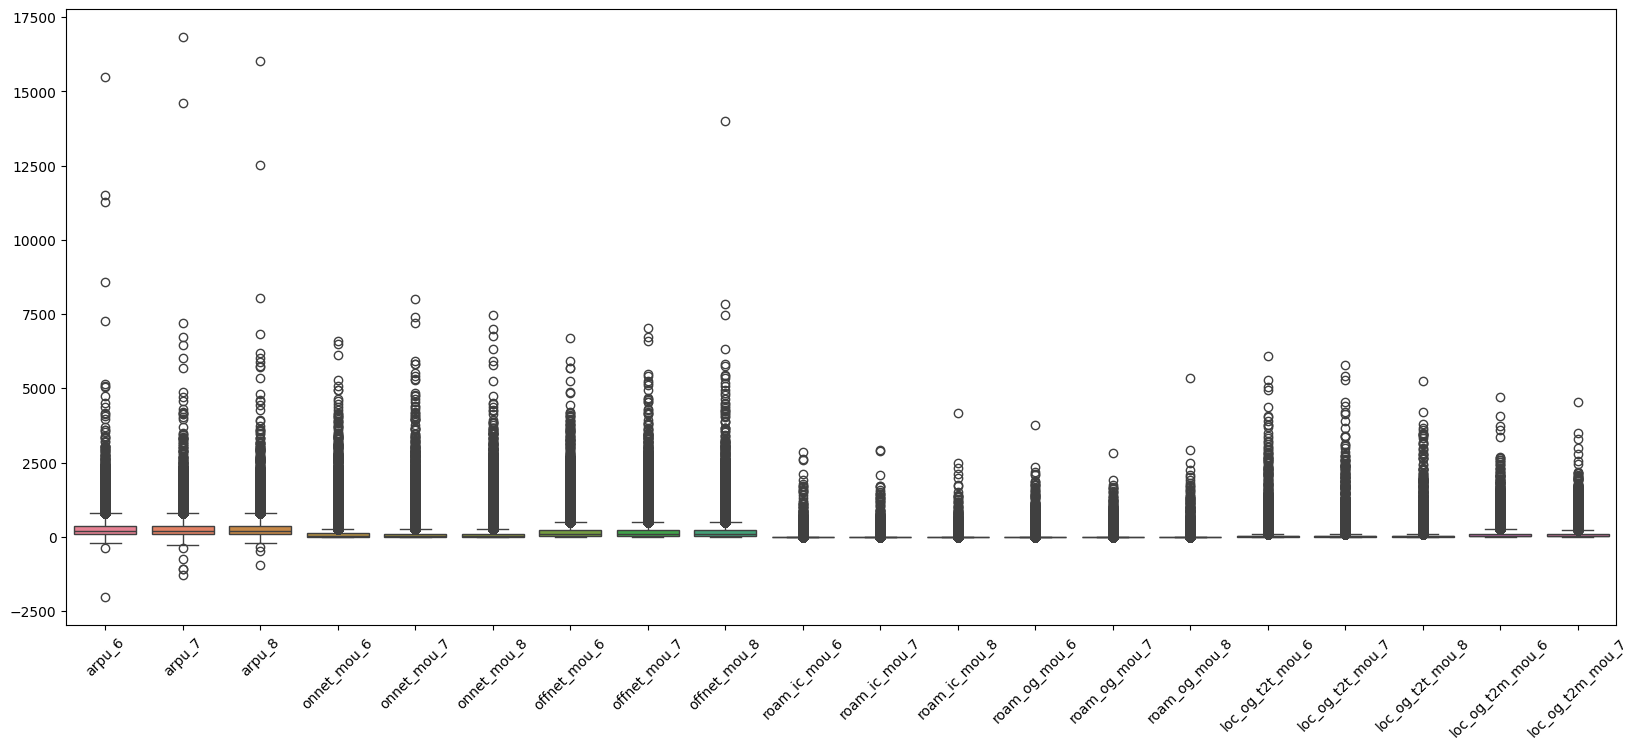

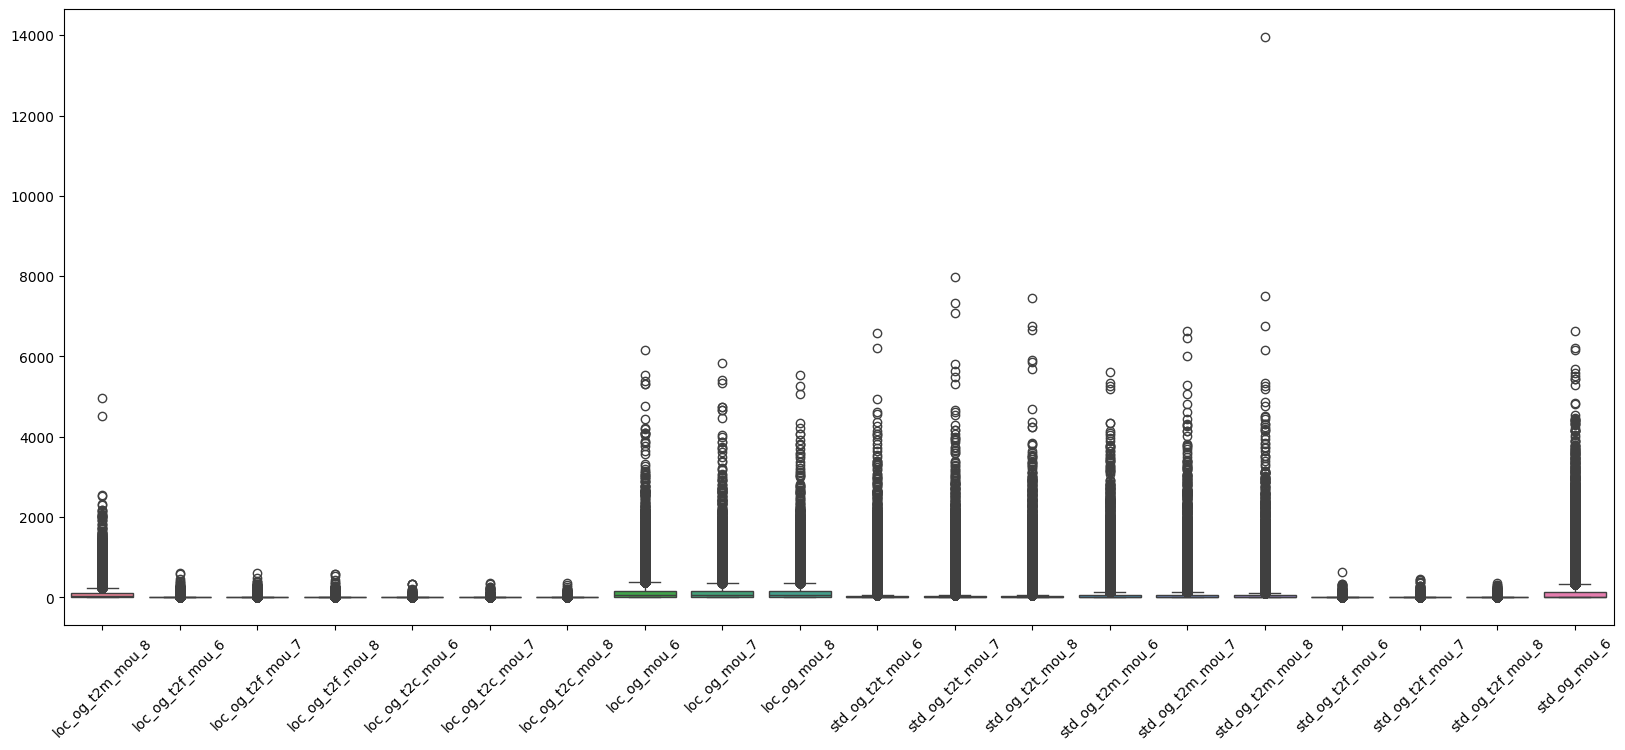

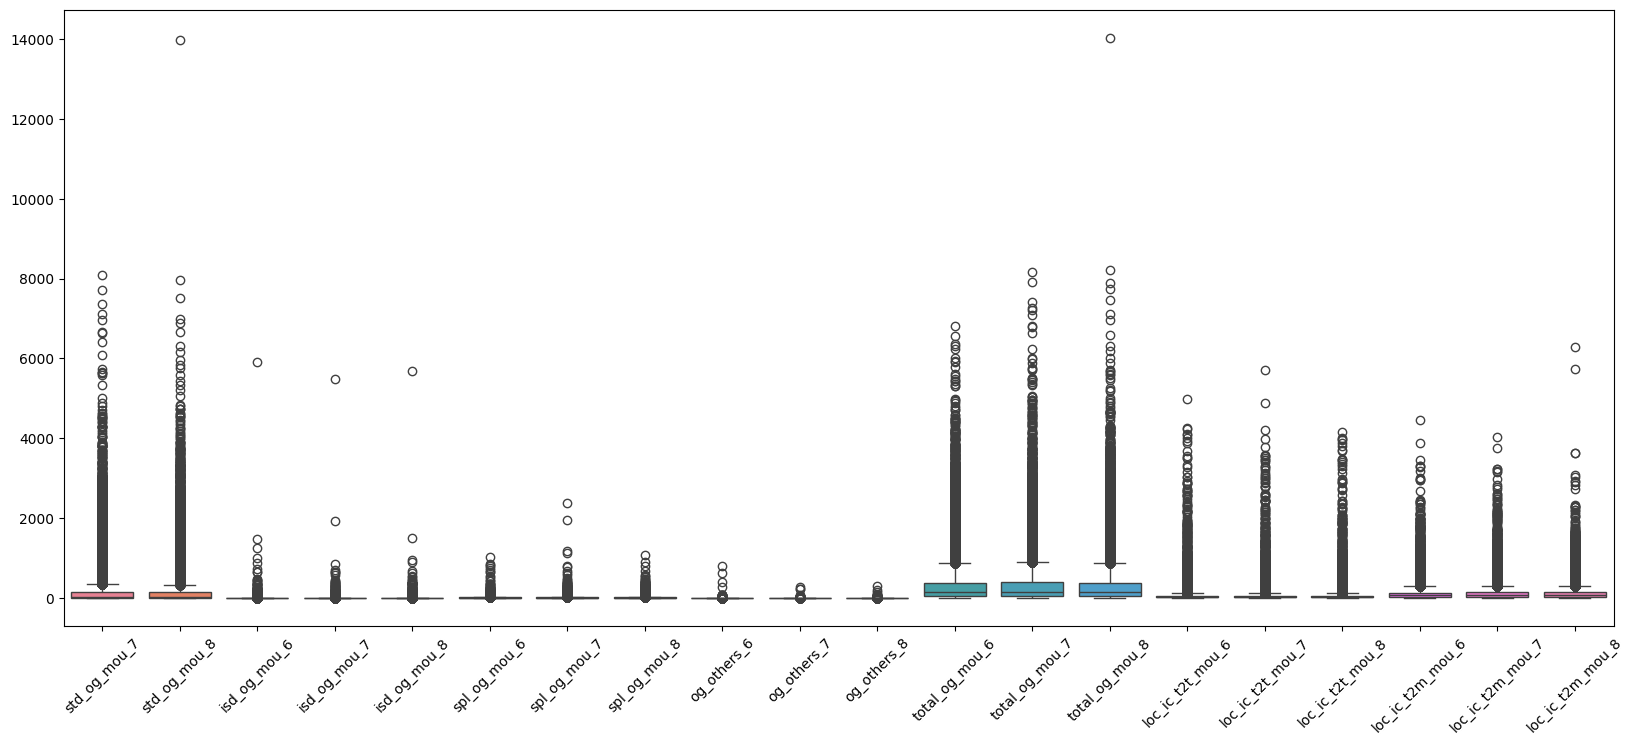

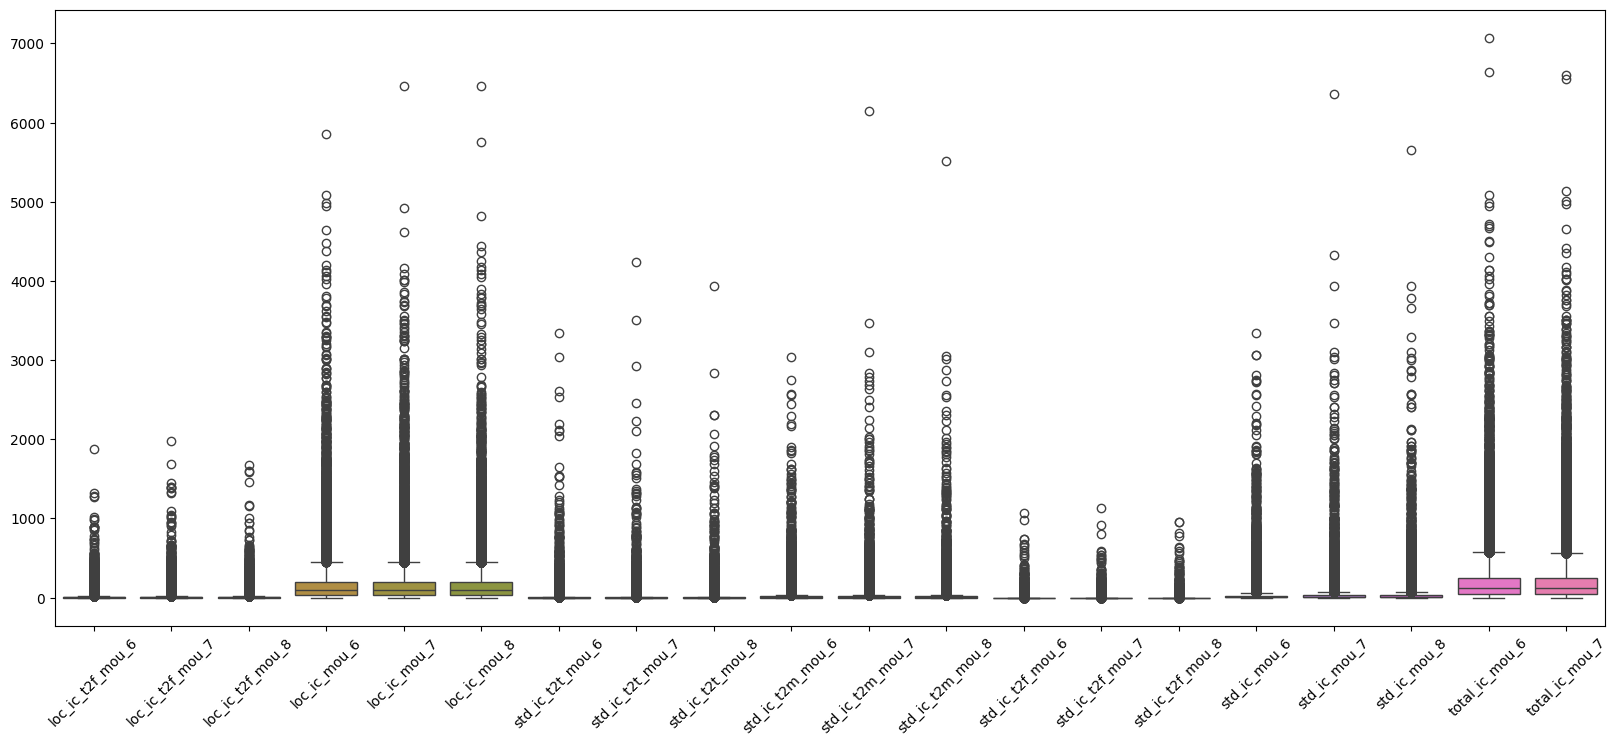

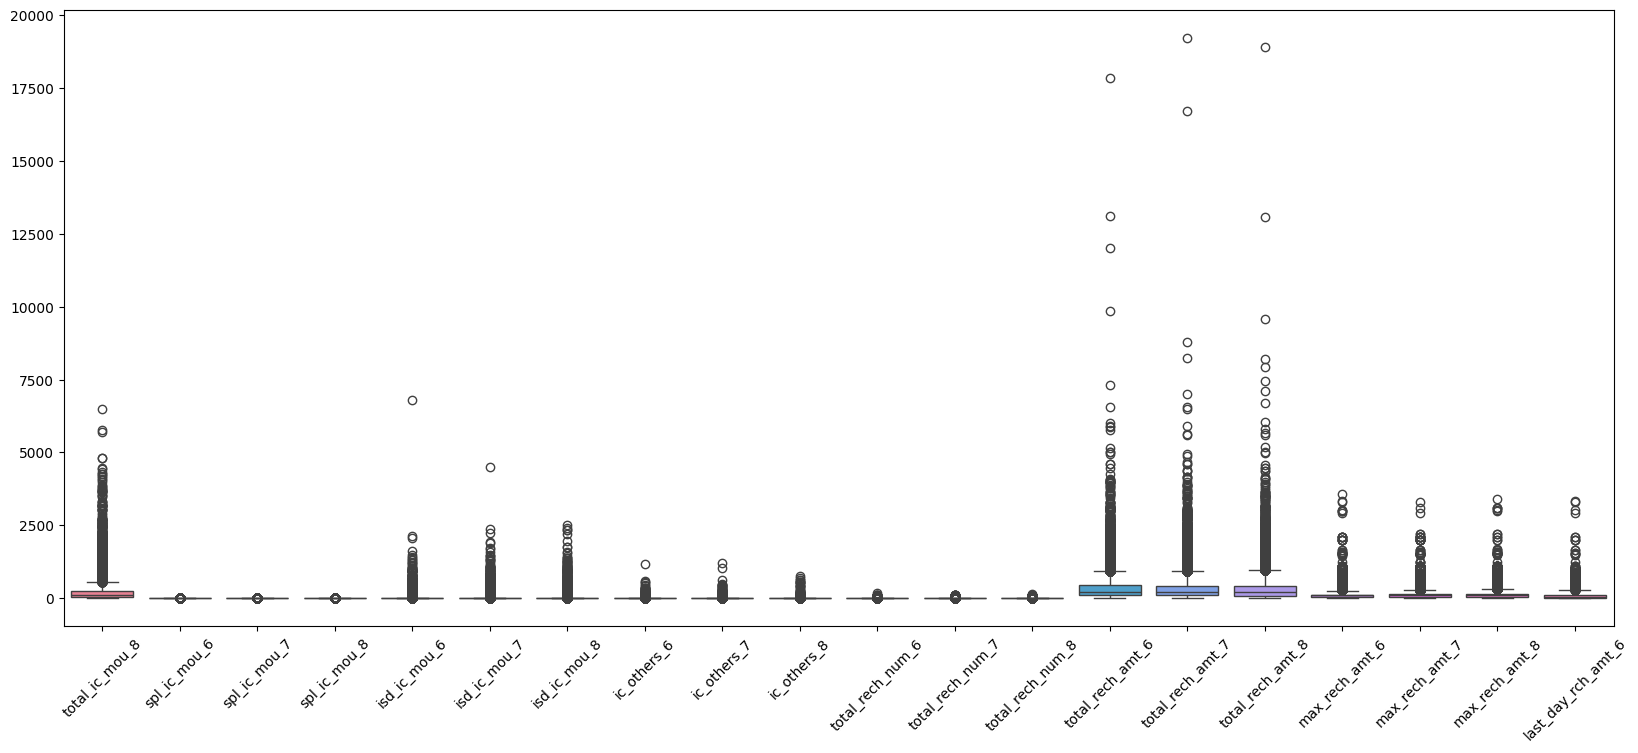

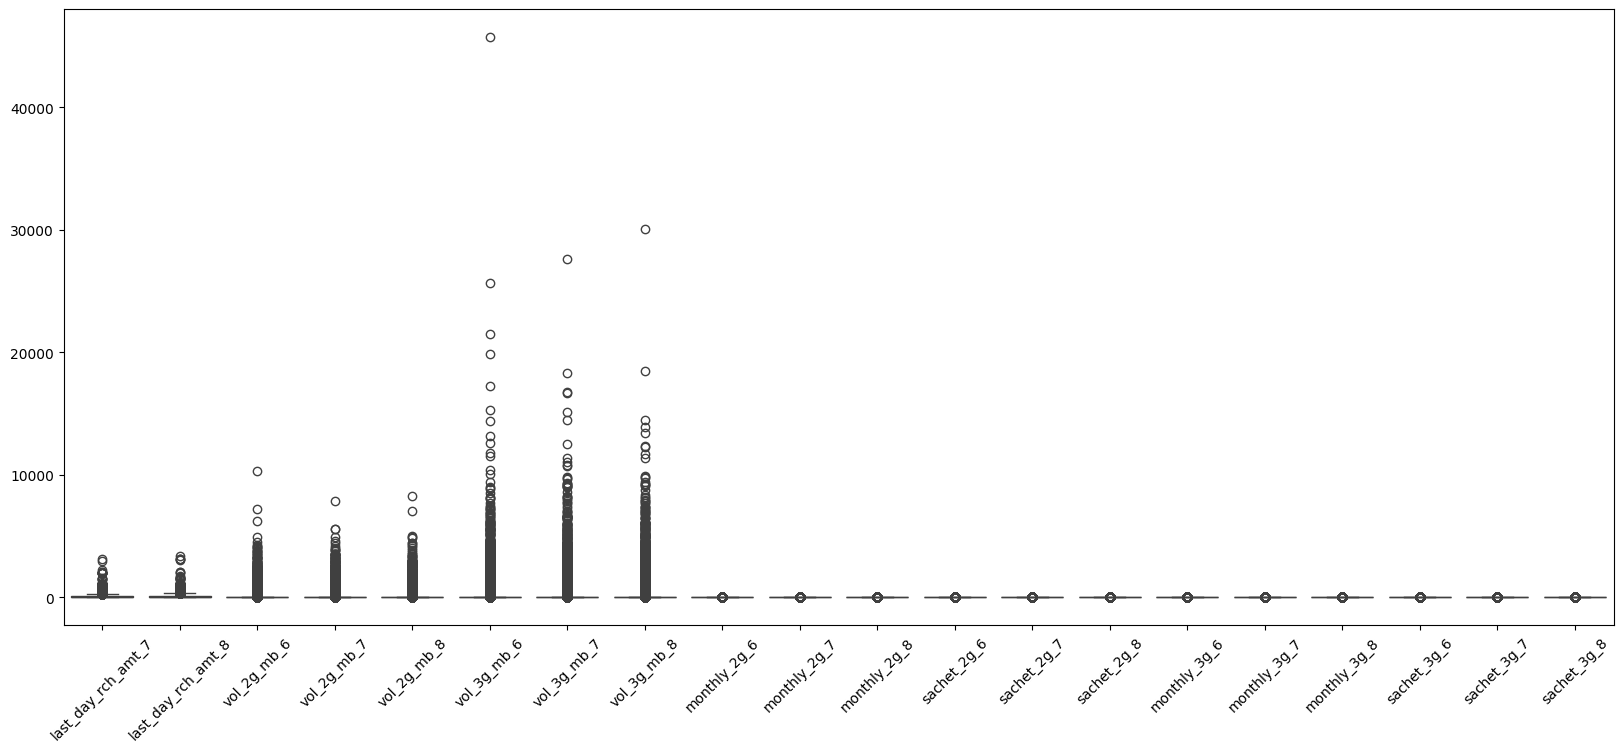

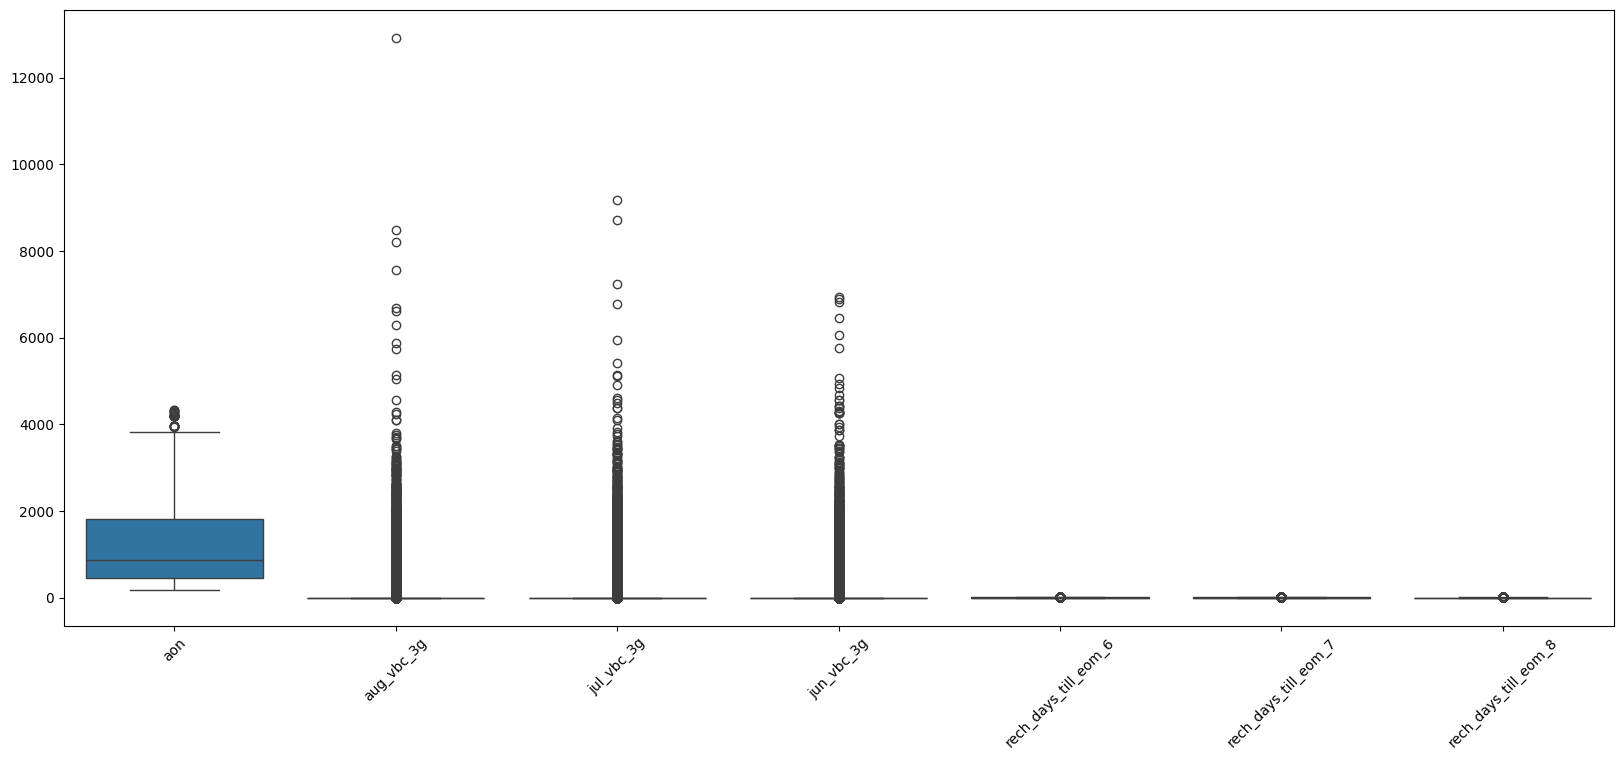

In [11]:
def chunks(lst, n):   
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
for x in list(chunks(data_s.X_train.columns, 20)):
    plt.figure(figsize=(20,8))
    plt.xticks(rotation=45)
    sns.boxplot(data = data_s.X_train[x.to_list()])
    plt.show()
    

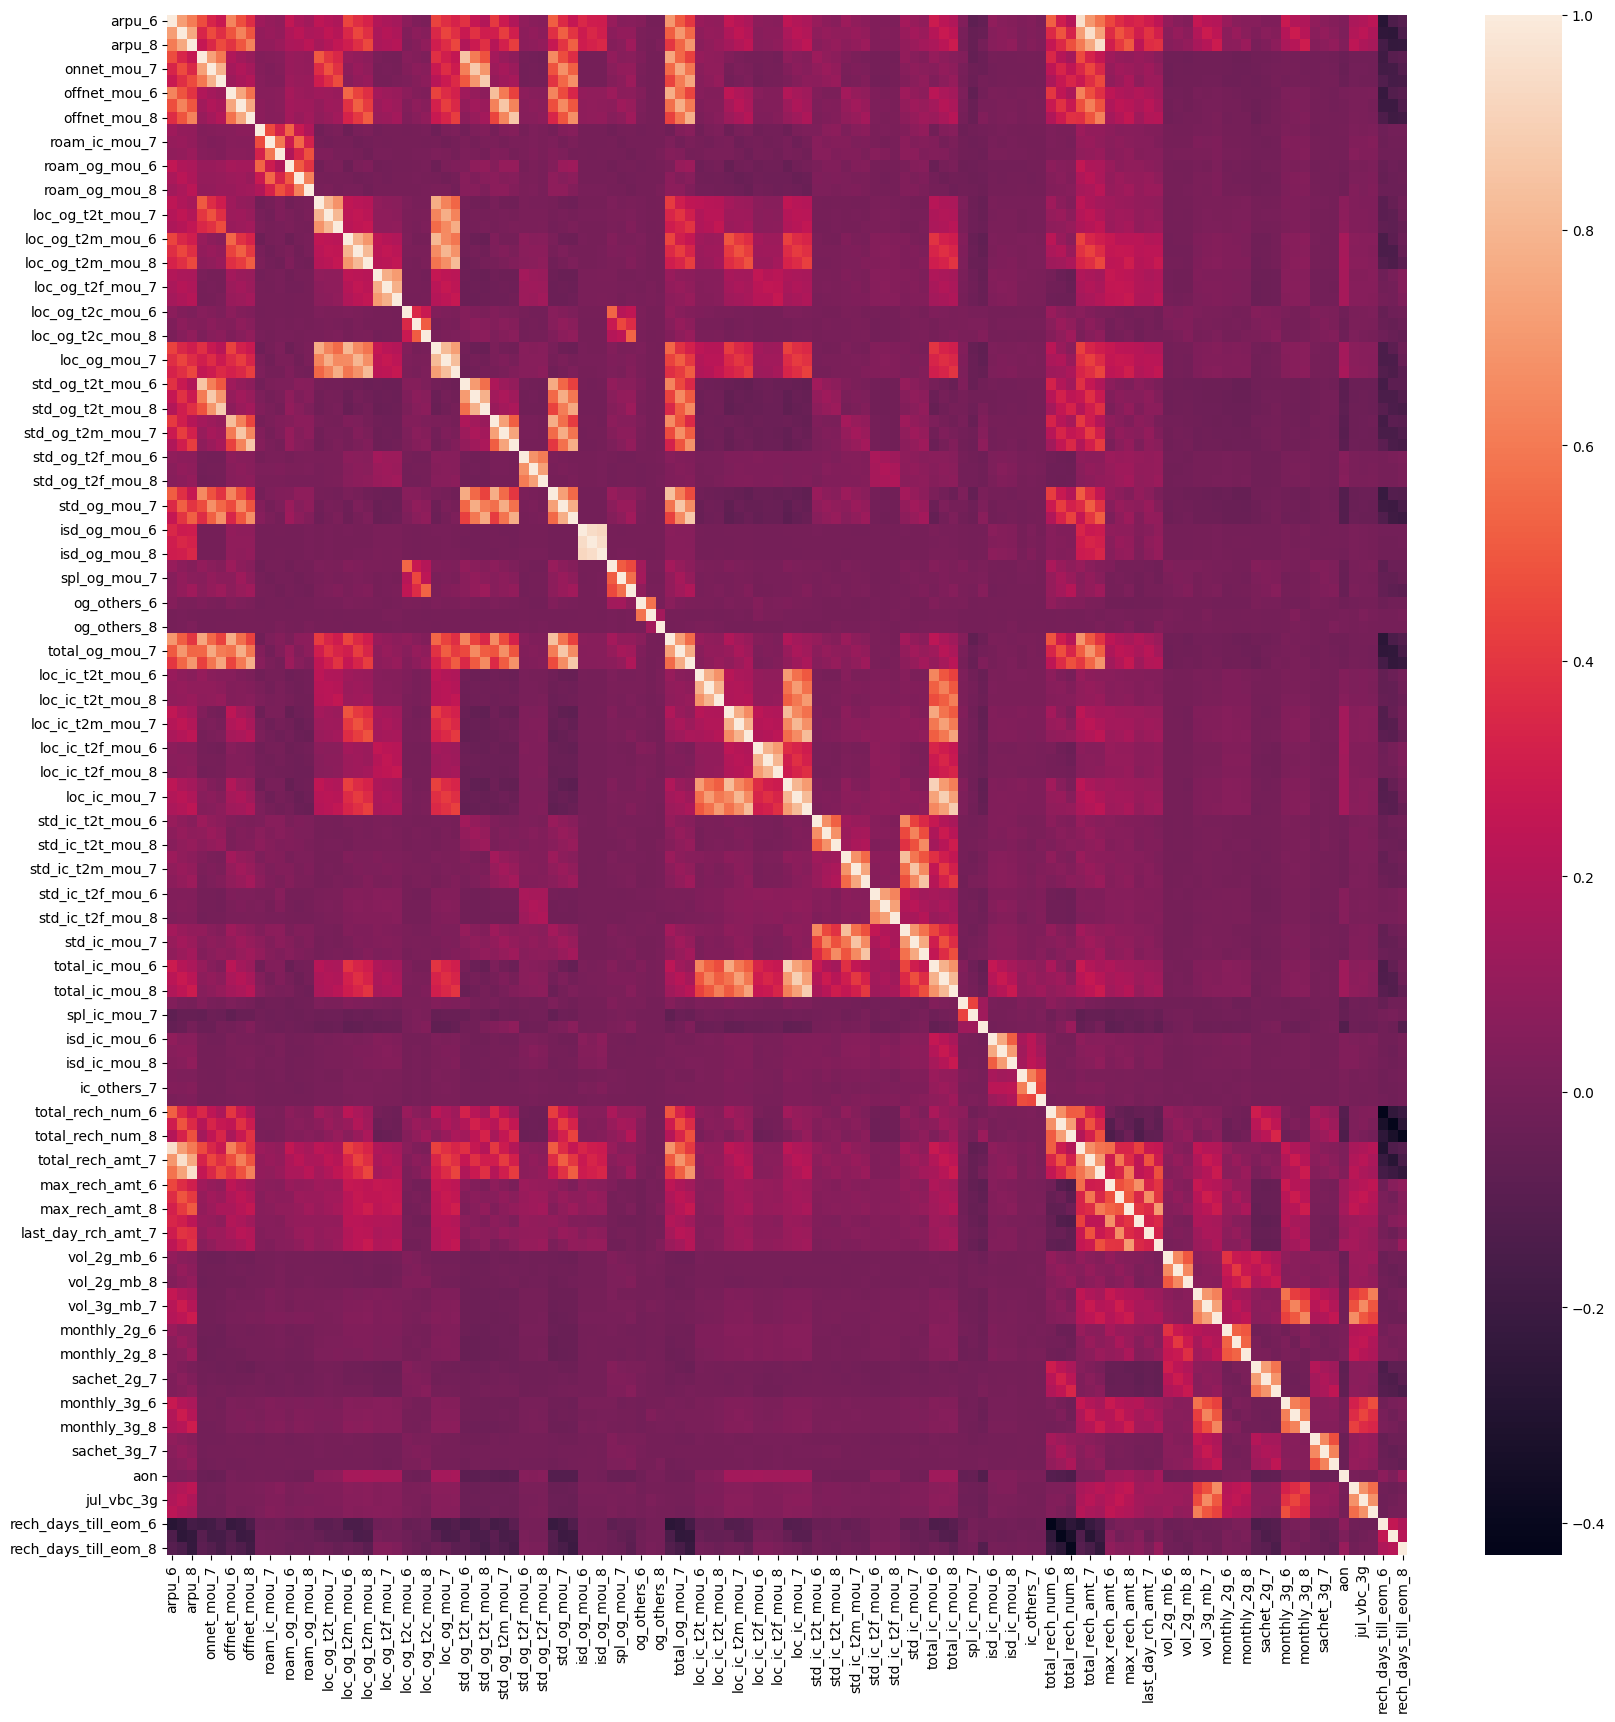

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.DataFrame(data_s.X_train, columns=data_s.X_train.columns).corr())
plt.show()

### Handle outliers

In [13]:
# Function to remove outliers
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

data_s.X_train = data_s.X_train.apply(cap_outliers, axis=0)

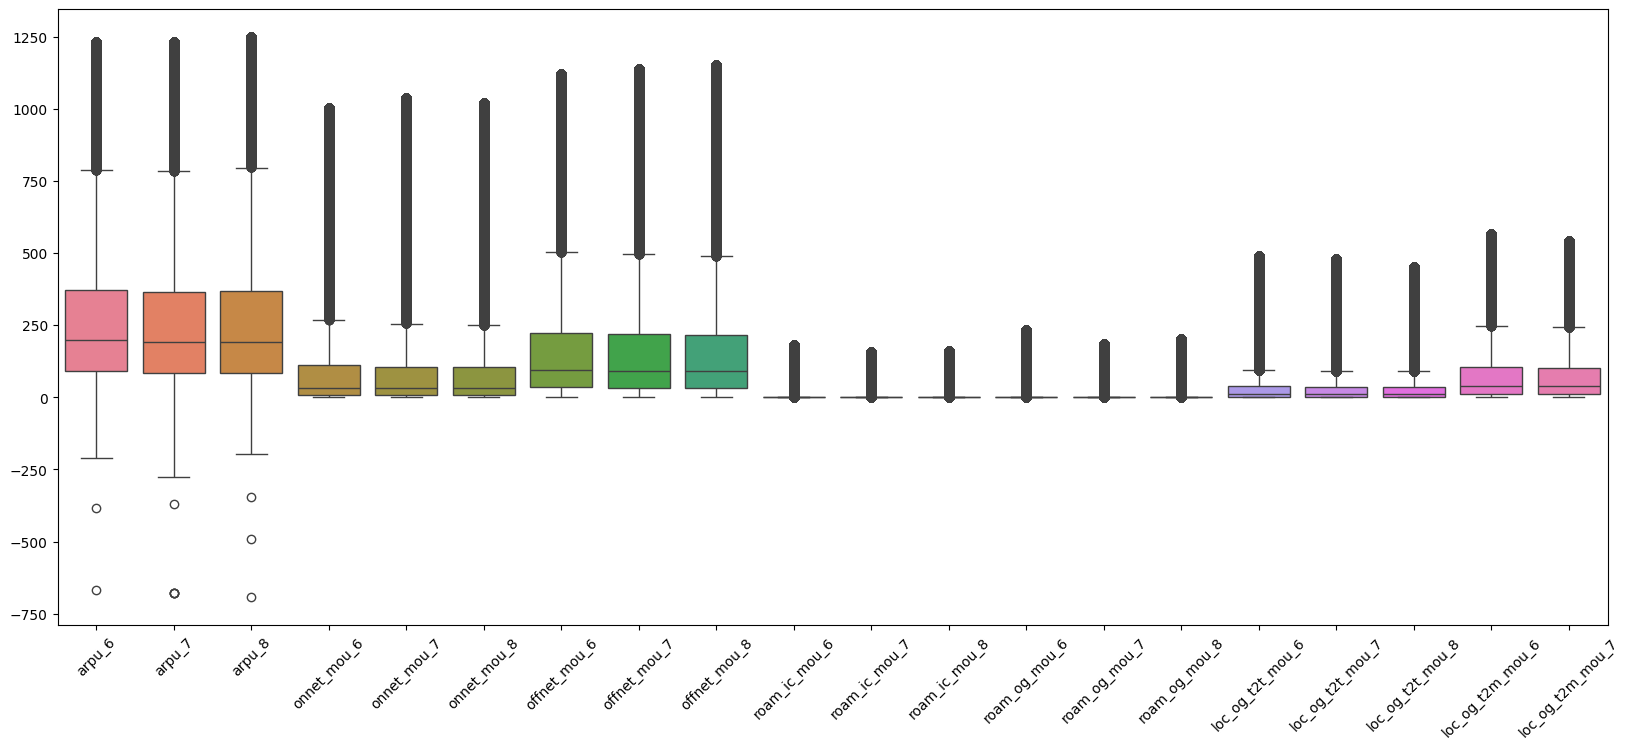

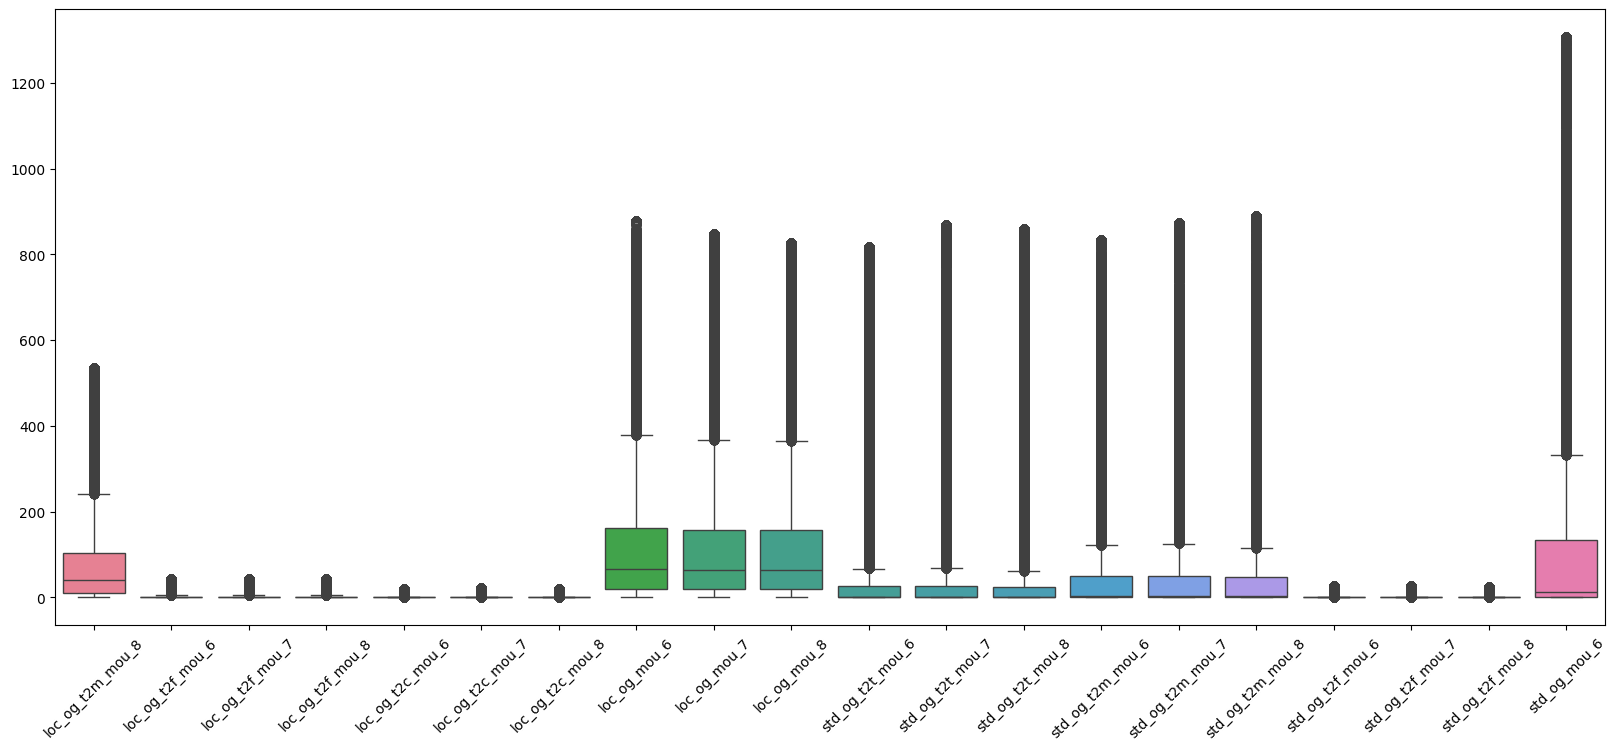

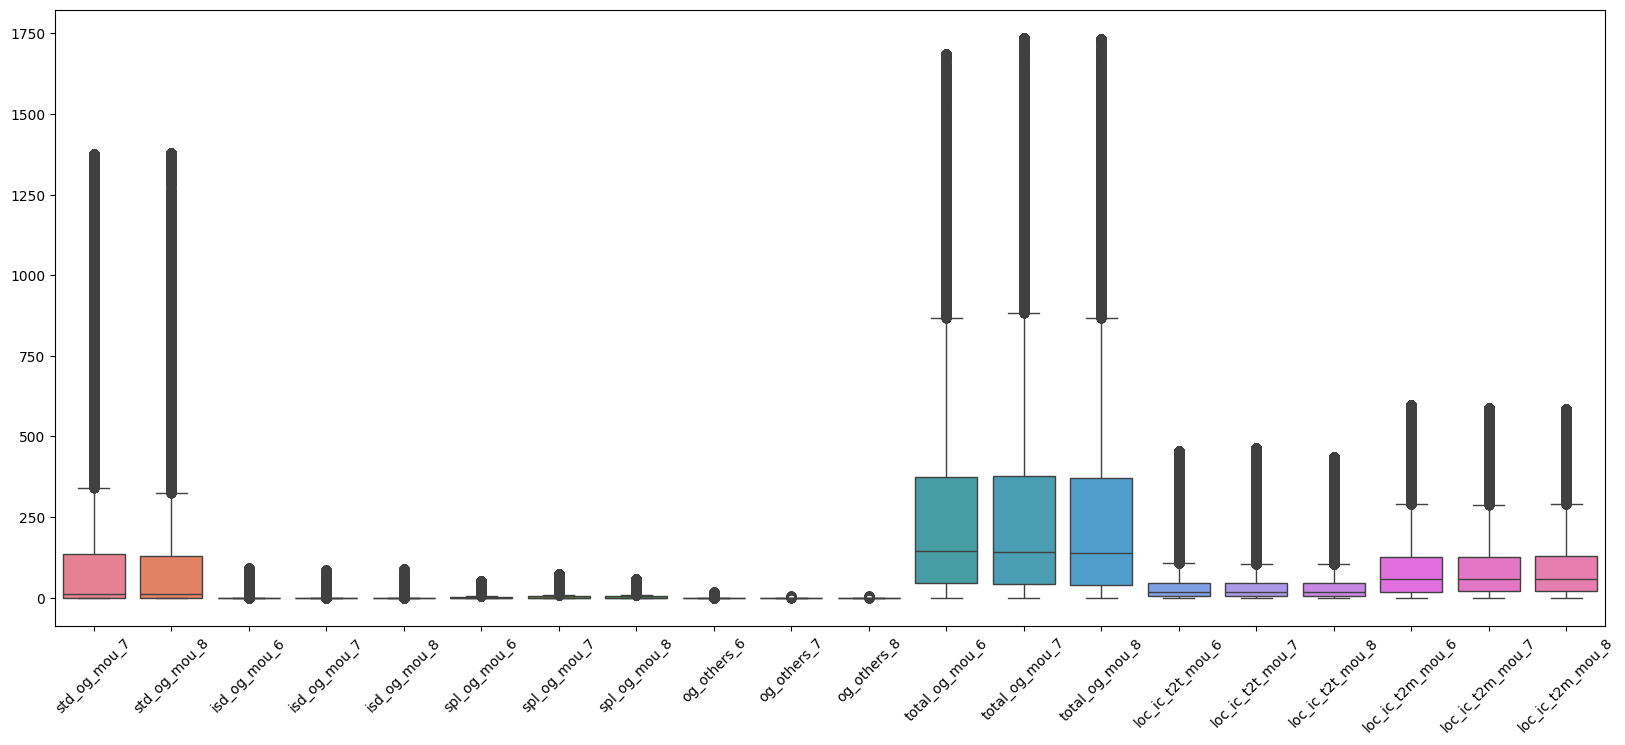

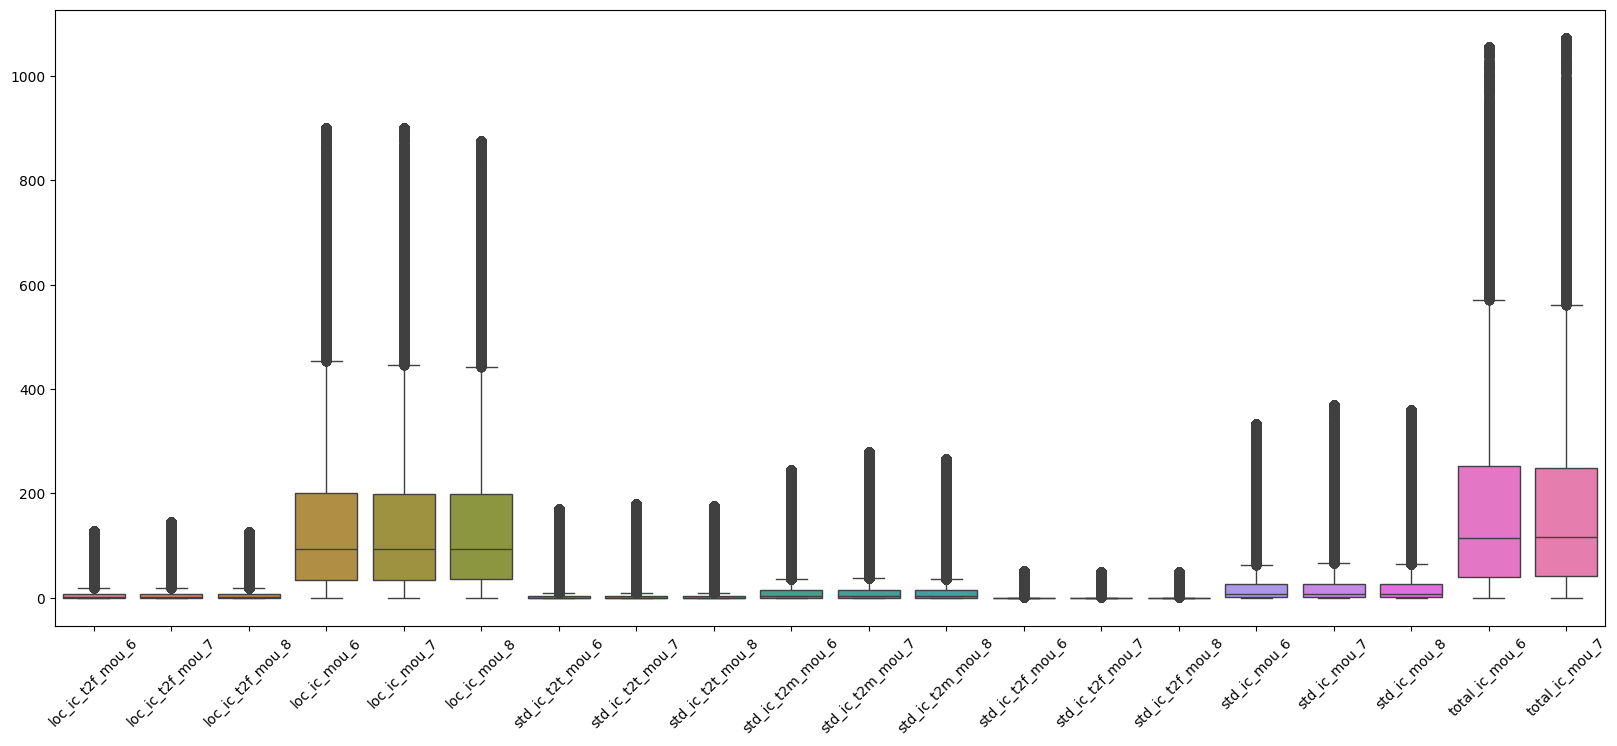

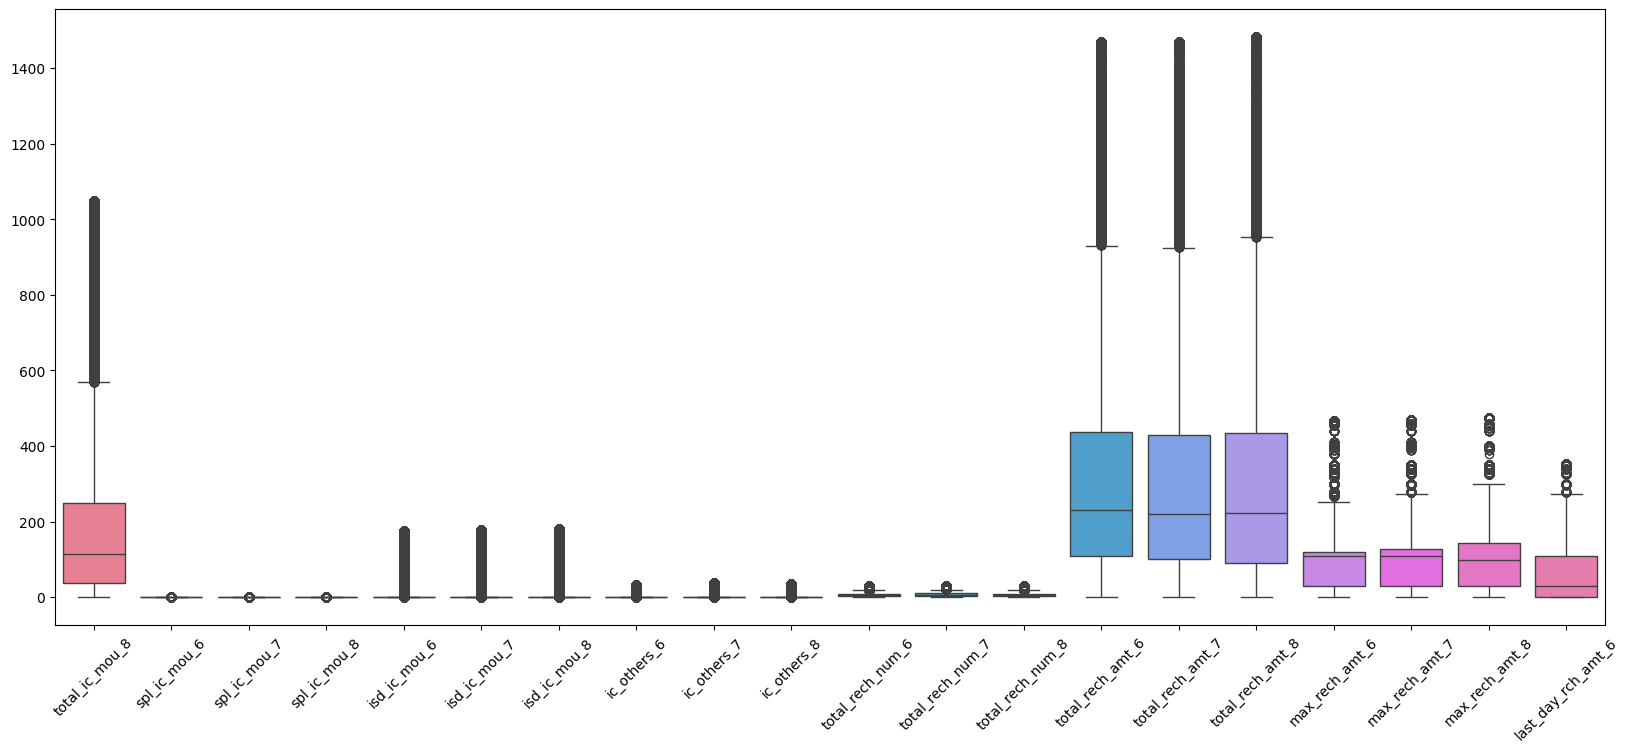

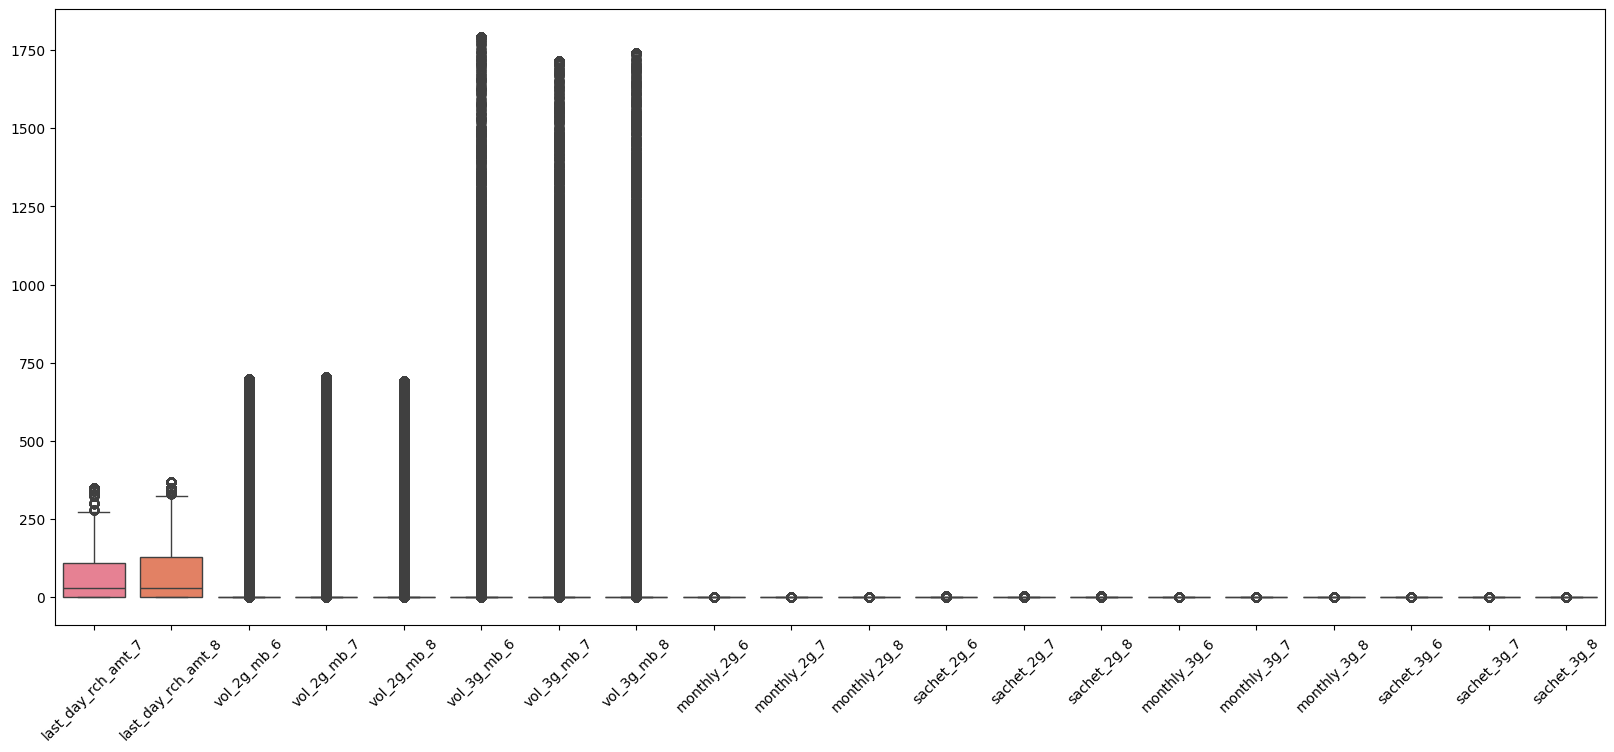

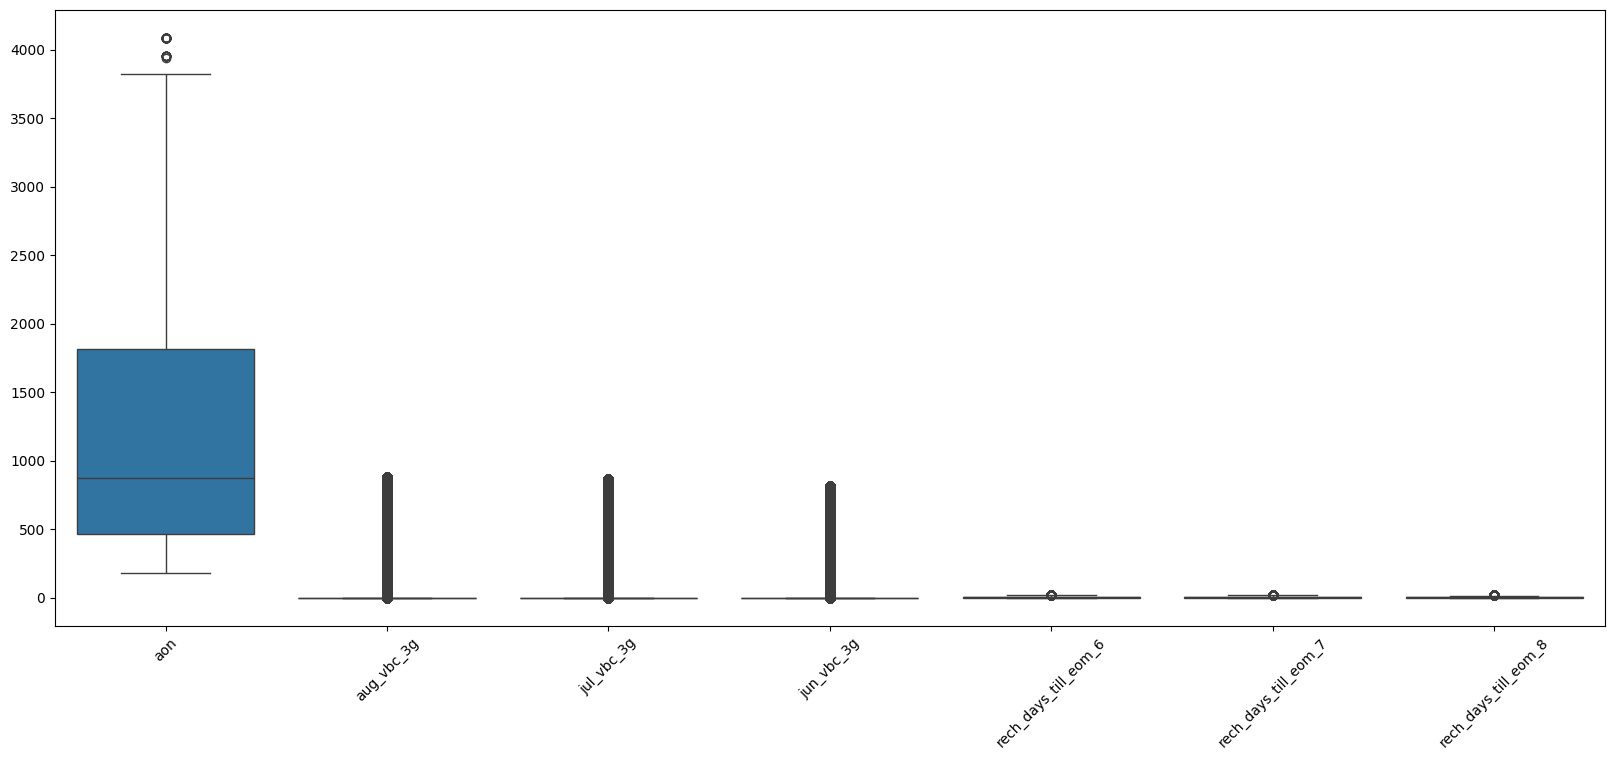

In [14]:
for x in list(chunks(data_s.X_train.columns, 20)):
    plt.figure(figsize=(20,8))
    plt.xticks(rotation=45)
    sns.boxplot(data = data_s.X_train[x.to_list()])
    plt.show()

# 4. Model building

In [15]:
# function to eval classifier
def eval_classifier(classifier, split_data):
    train_score = classifier.score(split_data.X_train, split_data.y_train)
    print("Training accuracy:", train_score)
    
    test_score = classifier.score(split_data.X_test, split_data.y_test)
    print("Test accuracy:", test_score)
    
    RocCurveDisplay.from_estimator(classifier, split_data.X_test, split_data.y_test)
    plt.show()

    y_test_pred = classifier.predict(split_data.X_test)
    print(classification_report(split_data.y_test, y_test_pred))
    

In [16]:
# function to plot Feature importances
def feature_importances_tree(classifier, split_data, n=10):
    f_i = pd.DataFrame({'col':split_data.X_train.columns, 'importance':classifier.feature_importances_})
    f_i.sort_values(by='importance', ascending=False, inplace=True)
    f_i_top_n = f_i[:n]
    plt.figure(figsize=(15,8))
    plt.xticks(rotation=45)
    plt.bar(f_i_top_n['col'], f_i_top_n['importance'])
    plt.show()
    

## Logistic Regression

We use linearly transformed (PCA) feature space to get the most explained variance from the least amount of features.

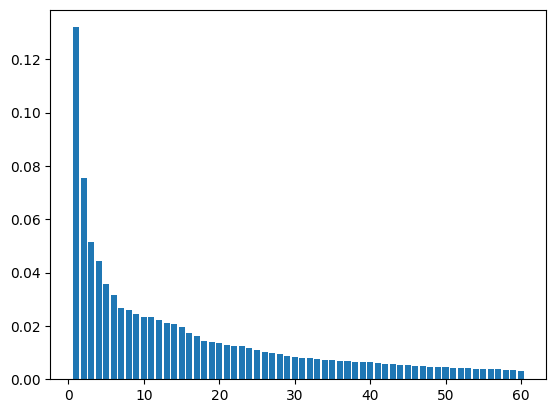

In [17]:
scaler_lr = StandardScaler()
data_lr.scale(scaler_lr)

pca = PCA()
pca_components = pca.fit_transform(data_lr.X_train)
plt.bar(range(1,len(pca.explained_variance_ratio_[:60])+1), pca.explained_variance_ratio_[:60])
plt.show()

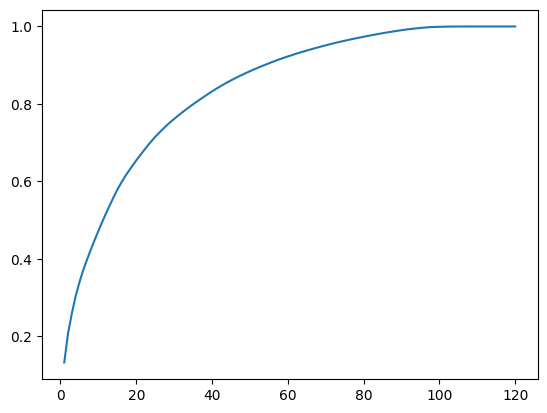

In [18]:
var_cumu = np.cumsum(pca.explained_variance_ratio_[:120])
plt.plot(range(1,len(var_cumu)+1), var_cumu)
plt.show()

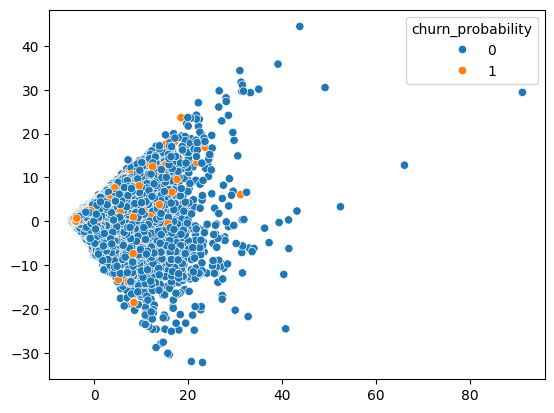

In [19]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=data_lr.y_train)
plt.show()

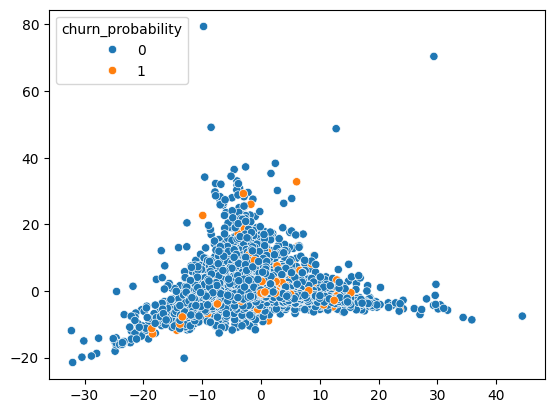

In [20]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=data_s.y_train)
plt.show()

In [21]:
scaler_lr = StandardScaler()
pca_lr = PCA(n_components=40)
lr = LogisticRegression(max_iter=1000, tol=0.001)

pipe_lr = Pipeline(steps = [('scaling',scaler_lr), ('pca', pca_lr), ('model',lr)])

pipe_lr.fit(data_s.X_train, data_s.y_train)

,steps,"[('scaling', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,40
,copy,True
,whiten,False
,svd_solver,'auto'


Training accuracy: 0.9057939957958325
Test accuracy: 0.8997142857142857


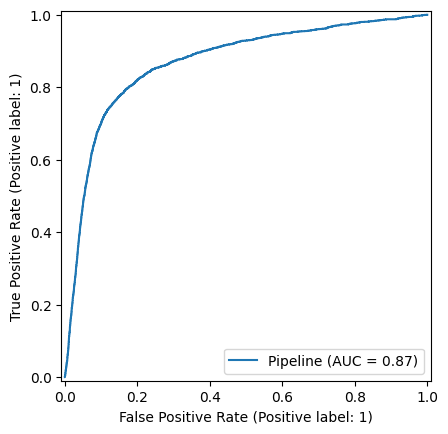

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     18841
           1       0.53      0.24      0.33      2159

    accuracy                           0.90     21000
   macro avg       0.72      0.61      0.64     21000
weighted avg       0.88      0.90      0.88     21000



In [22]:
eval_classifier(pipe_lr, data_s)

## Random Forrest Classifier

In [23]:
scaler_rf = StandardScaler()

rf = RandomForestClassifier(bootstrap=False, n_estimators=100, max_depth=34, max_features='sqrt',
                       min_samples_split=46, n_jobs=-1)

pipe_rf = Pipeline(steps = [('scaling',scaler_rf), ('model',rf)])

pipe_rf.fit(data_s.X_train, data_s.y_train)


,steps,"[('scaling', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'gini'
,max_depth,34
,min_samples_split,46


***Note: Hyper parameter tuning is included in the Appendix section, because it has a significant run time. It has been run  and the best model was copied here***

Training accuracy: 0.9624686218086084
Test accuracy: 0.9409047619047619


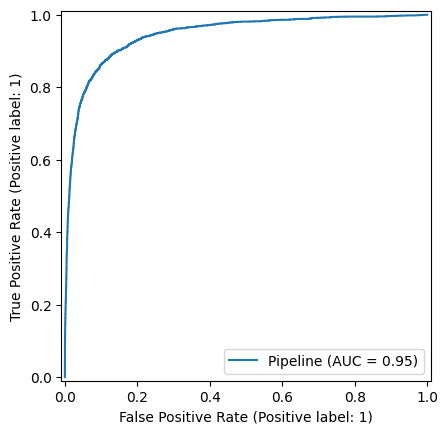

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     18841
           1       0.79      0.58      0.67      2159

    accuracy                           0.94     21000
   macro avg       0.87      0.78      0.82     21000
weighted avg       0.94      0.94      0.94     21000



In [24]:
eval_classifier(pipe_rf, data_s)

### Top 10 features by importance

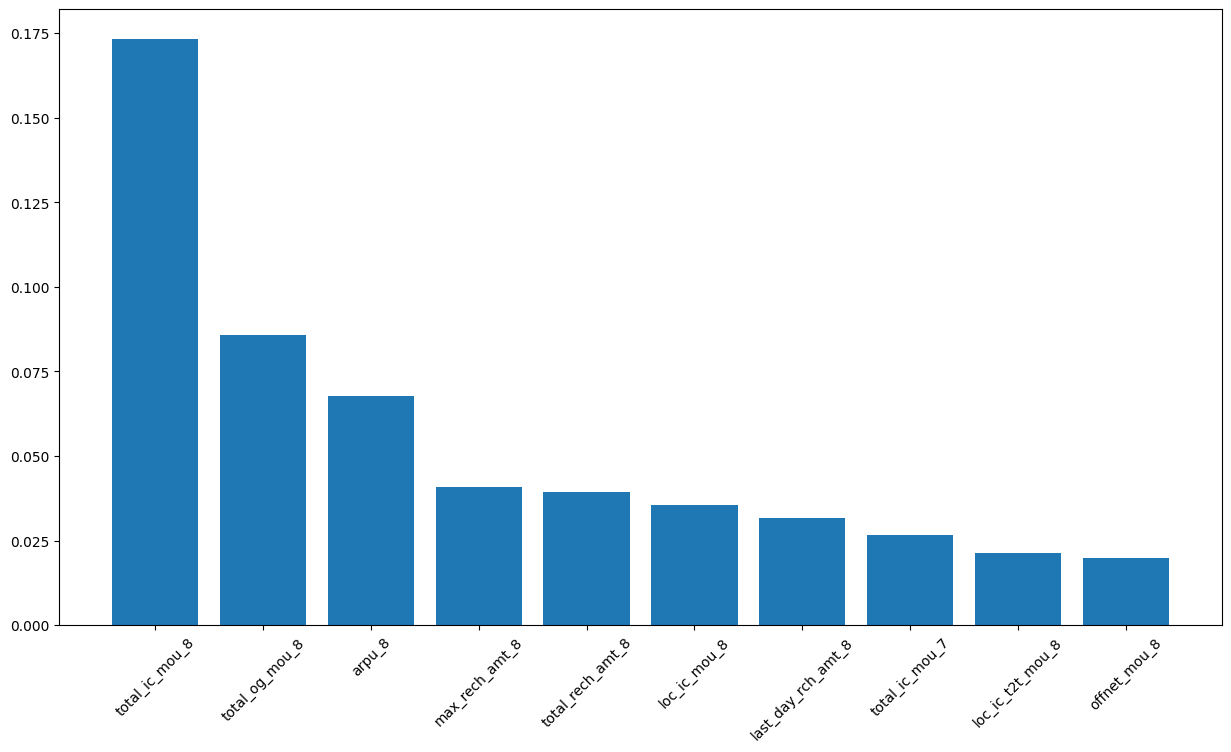

In [25]:
feature_importances_tree(rf, data_s)

## Gradient Boosting Classifier

We will use **Histogram Gradient Boosting Classifier** because it has better runtime performance without sacraficing much classification accuracy.  

In [26]:
scaler_gb = StandardScaler()

gb = HistGradientBoostingClassifier(l2_regularization=0, learning_rate=0.075, max_depth=13,
                               max_leaf_nodes=50, min_samples_leaf=16, random_state=90)

pipe_gb = Pipeline(steps = [('scaling',scaler_gb), ('model',gb)])

pipe_gb.fit(data_s.X_train, data_s.y_train)

,steps,"[('scaling', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'log_loss'
,learning_rate,0.075
,max_iter,100
,max_leaf_nodes,50


***Note: Hyper parameter tuning is included in the Appendix section, because it has a significant run time. It has been run  and the best model was copied here***

Training accuracy: 0.9558358333843547
Test accuracy: 0.9446666666666667


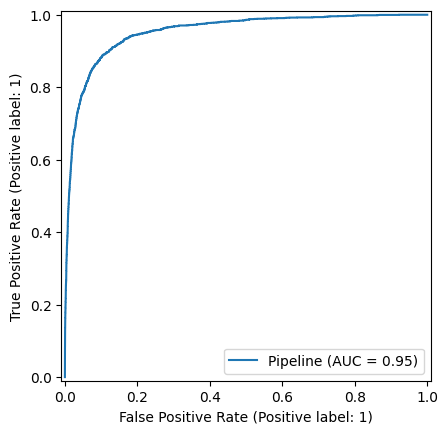

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18841
           1       0.77      0.66      0.71      2159

    accuracy                           0.94     21000
   macro avg       0.87      0.82      0.84     21000
weighted avg       0.94      0.94      0.94     21000



In [27]:
eval_classifier(pipe_gb, data_s)

**This is considered the final model**

# Appendix

## A1. Hyper-parameter tuning

### A1.1 Random Forrest hyper-parameter tuning

In [119]:
# Set hyperparameters possibilities for tuning Random Forest
rf_max_depth = [int(x) for x in np.linspace(3, 55, 11)]
rf_max_features = ['sqrt', 'log2']
rf_criterion = ['gini', 'entropy']
rf_min_samples_split = [int(x) for x in np.linspace(5, 60, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': [50, 100, 150],
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [50, 100, 150],
 'max_depth': [3, 8, 13, 18, 23, 29, 34, 39, 44, 49, 55],
 'max_features': ['sqrt', 'log2'],
 'criterion': ['gini', 'entropy'],
 'min_samples_split': [5, 11, 18, 25, 32, 39, 46, 53, 60],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [ ]:
# Tune the Random Forest Model
# effective n_iter=50-100
rf_base = RandomForestClassifier(n_jobs=1)
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 5, cv = 3, verbose = 10, random_state = 42, 
                               n_jobs = 7)

rf_random.fit(data_s.X_train, data_s.y_train)

rf_random.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


***Note: Hyper-parameter tuning n_iter is set to 5 for evaluation purposes. It has been run with more iterations and best model has been copied to Model building section***

### A1.2 Histogram Gradient Boost hyper-parameter tuning

In [107]:
# Histogram Gradient boost hyper parameter tuning
# Set hyperparameters possibilities for tuning Gradient boost
gb_max_depth = [int(x) for x in np.linspace(3, 55, 11)]
gb_max_features = ['sqrt', None]
gb_min_samples_leaf = [int(x) for x in np.linspace(10, 80, 12)]
gb_min_impurity_decrease = [0.0, 0.05, 0.1]
gb_learning_rate = [0.05, 0.075, 0.1, 0.125, 0.15]

# Create the grid
gb_grid = {
    'max_depth': gb_max_depth,
    'min_samples_leaf': gb_min_samples_leaf,
    'max_leaf_nodes': [31, 50],
    'learning_rate': gb_learning_rate,
    'l2_regularization': [0, 0.05, 0.1],
}

gb_grid

{'max_depth': [3, 8, 13, 18, 23, 29, 34, 39, 44, 49, 55],
 'min_samples_leaf': [10, 16, 22, 29, 35, 41, 48, 54, 60, 67, 73, 80],
 'max_leaf_nodes': [31, 50],
 'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15],
 'l2_regularization': [0, 0.05, 0.1]}

In [ ]:
# Tune the HistGradientBoostingClassifier Model
# effective n_iter=100
gb_base = HistGradientBoostingClassifier()
gb_random = RandomizedSearchCV(estimator = gb_base, param_distributions = gb_grid, 
                               n_iter = 5, cv = 3, verbose = 10, random_state = 42, 
                               n_jobs = 7)

gb_random.fit(data_s.X_train, data_s.y_train)

gb_random.best_estimator_

***Note: Hyper-parameter tuning n_iter is set to 5 for evaluation purposes. It has been run with more iterations and best model has been copied to Model building section***